In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision
from torchvision import transforms
from scipy import fft
import math

# Download the MNIST dataset

In [8]:
trainset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())

In [9]:
train_X_wide = trainset.data.numpy()
train_Y_int = trainset.targets.numpy()

# Chop two pixels off the boundary of the image to make Sigma_xx full rank

In [10]:
train_X_cut = np.reshape(train_X_wide[:,2:26,2:26],(-1,24,24))

# Processing the data

In [11]:
### Let train_X be a 60,000 x 576 matrix. Each row of train_X is the flattened matrix representing each image 
### transpose train_X at the end to make it a 576 x 60,000 matrix
train_X = np.ndarray(shape=(60000, 24*24))

for i in range(60000):
    ###transform the 24x24 matrix into a 24^2 = 576 dimensional vector using the flatten command
    train_X[i] = train_X_cut[i].flatten()
        
train_X = np.transpose(train_X)

In [12]:
### Let train_Y be a 60,000 x 10 matrix. Each row of train_Y is a one-hot vector representing the image label 0 through 9
### If the image label is 0, the one hot representation will be [1,0,0,...,0]. 
### If label is 1, the one hot vector will be [0,1,0,0,...,0] and so on.

train_Y = np.zeros(shape = (60000, 10))

for i in range(60000):
    train_Y[i][train_Y_int[i]] = 10000

train_Y = np.transpose(train_Y)

# Full Batch Sigma_xx & Sigma_yx, W_optimal

In [13]:
### Calculate sigma_xx, sigma_yx for the full dataset

sigma_xx_full = np.zeros((576, 576))
sigma_yx_full = np.zeros((10, 576))

for i in range(60000):
    x = train_X[:,i].reshape((576,1))
    y = train_Y[:,i].reshape((10,1))
    sigma_xx_full += x * x.T
    sigma_yx_full += y * x.T
    
sigma_xx_full = sigma_xx_full / 60000
sigma_yx_full = sigma_yx_full / 60000

In [14]:
sigma_xx_inv = np.linalg.inv(sigma_xx_full)

In [15]:
W_optimal = np.matmul(sigma_yx_full, sigma_xx_inv)

# Define Error

In [16]:
def getCosError(W1, W2):
    ### returns (1-cosine) value of the angle between two "vectors" W1 and W2
    return 1.0-(np.sum(np.multiply(W1, W2)) / (np.linalg.norm(W1) * np.linalg.norm(W2)))

# Mini Batch Gradient Descent

In [17]:
### randomly select a minibatch and compute sigma_xx, sigma_yx
def generate_minibatch(batch_size):
    sample = random.sample(range(60000), batch_size)
    x_minibatch = train_X[:,sample]
    y_minibatch = train_Y[:,sample]
    
    sigma_xx = np.zeros((576, 576))
    sigma_yx = np.zeros((10, 576))
    
    for i in range(batch_size):
        x = x_minibatch[:,i].reshape((576,1))
        y = y_minibatch[:,i].reshape((10,1))
        sigma_xx += x * x.T
        sigma_yx += y * x.T
        
    sigma_xx = sigma_xx / batch_size
    sigma_yx = sigma_yx / batch_size
    
    return (sigma_xx, sigma_yx)

In [20]:
#randomly initialize W
W = W_optimal + 0.5 * np.random.randn(10, 576)

In [24]:
max_epochs = 15000000
converging_range = 10000

learning_rate = 0.0000002
error_list = []

###list to save W's and sigma_yx's for later analysis
W_list=[]
sigma_yx_list=[]

for epoch in range(0, max_epochs + 1):
    ###calculating error for every 100th epoch to reduce running time
    if epoch % 100 == 0:
      error_list.append(getCosError(W, W_optimal))
    
    #generating minibatch
    (mb_sigma_xx,mb_sigma_yx)=generate_minibatch(5)
    
    #saving W's and sigma_yz's only in converging range
    if epoch > max_epochs - converging_range:
        W_list.append(W)
        sigma_yx_list.append(mb_sigma_yx)
    
    #gradient descent
    W = W + learning_rate*np.matmul(-W, mb_sigma_xx) + learning_rate*mb_sigma_yx

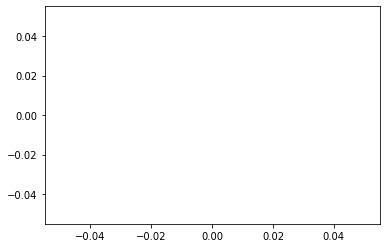

In [25]:
#plotting error list to see convergence
plt.plot(error_list[1:])

# Defining Sigma WW, D, and SigmaXXSigmaWW+SigmaWWSigmaXX

In [26]:
sigma_WW=np.zeros((576,576))
D=np.zeros((576,576))
interval_length=len(W_list)

for n in range(interval_length):
    W = W_list[n] - W_optimal
    sigma_WW += np.matmul(W.T,W)
    sigma_yx = sigma_yx_list[n] - sigma_yx_full
    D += np.matmul(sigma_yx.T,sigma_yx)
    
sigma_WW/=interval_length
D/=interval_length
sigma_XXWW = np.matmul(sigma_xx_full,sigma_WW)+np.matmul(sigma_WW,sigma_xx_full)

# Matrix Contour Plots

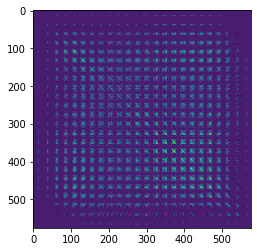

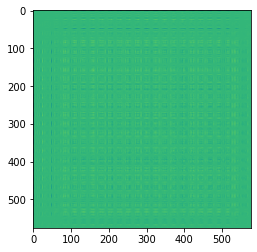

In [27]:
#Contour plot of D
plt.imshow(D, interpolation = 'nearest')
plt.show()
#Contour plot of SigmaXXSigmaWW+SigmaWWSigmaXX
plt.imshow(sigma_XXWW, interpolation = 'nearest')
plt.show()

# FFT Analysis of D and SigmaXXSigmaWW+SigmaWWSigmaXX

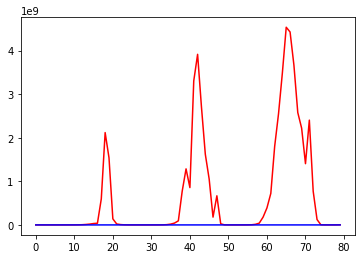

In [28]:
DPI = 200
output_range = 500
brightness_adjusting_factor = 1

def to_image(complex_input):
     output = np.abs(complex_input)**(1/brightness_adjusting_factor)
     return output

def plott(im, title=""):
    if (type(im[0,0]) == np.complex128):
        im = to_image(im)
    fig = plt.figure(dpi=DPI)
    plt.matshow(im)
    plt.title(title)
    
n = 0
X = []
Y = []

a=20
b=100
for i in range(a,b): #First row of FFT of D
     x = D[0][i]
     X.append(x)
for i in range(a,b): #First row of FFT of sigma_XXWW
     y = sigma_XXWW[0][i]
     Y.append(y)
t = np.arange(a,b,1)

plt.figure(1)
plt.plot(X/D[0][0],'r');
plt.plot(Y/sigma_XXWW[0][0],'b')
plt.show()

# Q Analysis

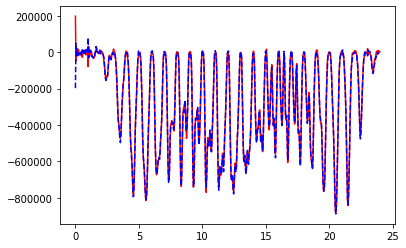

1.0000003061469185
0.984005283754838


In [29]:
A = np.matmul(sigma_WW,sigma_xx_full) + np.matmul(sigma_xx_full, sigma_WW) # D matrix
B = np.matmul(sigma_WW,sigma_xx_full) - np.matmul(sigma_xx_full, sigma_WW) # Q matrix

x = 0
y = 0

X = []
Y = []

## graphing 10th row of D and Q matrices
for i in range(0, 576):
     x = A[10][i]
     X.append(x)
for i in range(0, 576):
     y = B[10][i]
     Y.append(y)

t = np.arange(0, 576,1)
plt.figure(1)
plt.plot(t/24, X,'r')
plt.plot(t/24, Y,'b--')
plt.show()

print(abs(B).max()/abs(A).max()) # Comparing maximum value of D and Q matrices
print(abs(B).sum() / abs(A).sum()) # Comparing sum of absolute value of D and Q matrices' elements

# FFT Analysis of Q

<Figure size 432x288 with 0 Axes>

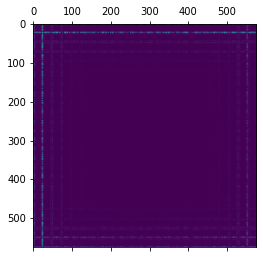

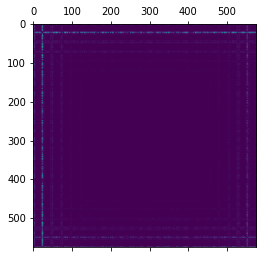

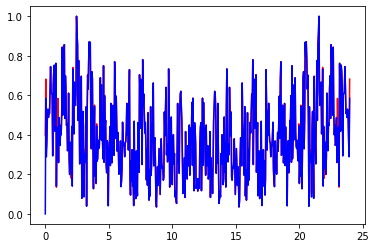

In [30]:
A_fft = np.abs(fft.fft2(A)) # FFT of D matrix and absolute braket for plotting
B_fft = np.abs(fft.fft2(B)) # FFT of Q matrix and absolute braket for plotting

plt.figure(1)
plt.matshow(A_fft)
plt.figure(2)
plt.matshow(B_fft)
plt.show()

E = []
G = []
for i in range(0, 576):
     e = A_fft[0][i]/(A_fft.max()) # first row of normalised FFT of D
     E.append(e)
for i in range(0, 576):
     g = B_fft[0][i]/(B_fft.max()) # first row of normalised FFT of Q
     G.append(g)
t = np.arange(0, 576,1)

plt.figure(1)
plt.plot(t/24, E,'r')
plt.plot(t/24, G,'b')

plt.show()